  #                   Проект: Обучение с учителем: качество модели

    Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
   
    В рамках данного проекта я являюсь сотрудником отдела цифровых технологий компании и мне предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность
   
**Подход к решению данной задачи** уже сформирован:

       1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
       2. Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте. 
       3. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
       4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
       5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных**
    
    Данные для работы находятся в нескольких таблицах.
    
    1. market_file.csv - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    2. market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    3. market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    4. money.csv - таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
    
    


In [7]:
!pip install --upgrade scikit-learn -q
!pip install shap -q

In [8]:
#импортируем все библиотеки, которые будем использовать при выполнении проектной работы 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import sklearn

from scipy import stats as st
from scipy.stats import binom
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

## Загрузка данных

In [9]:
# Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы
market_file = pd.read_csv('market_file.csv', sep=',', decimal='.')
market_money = pd.read_csv('market_money.csv', sep=',', decimal='.')
market_time = pd.read_csv('market_time.csv', sep=',', decimal=',')
money = pd.read_csv('money.csv', sep=';', decimal=',')

In [10]:
# Выведем первые строки каждого набора данных, посмотри основную информацию
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [11]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [12]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [13]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [14]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [15]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [16]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Загрузили и изучили данные:

Датафрейм market_file содержит 1300 строк, 13 столбцов

Датафрейм market_money содержит 3900 строк, 3 столбца

Датафрейм market_time содержит 2600 строк, 3 столбца

Датафрейм money содержит 1300 строк, 2 столбца

Данные в таблицах соотвествуют описанию, выглядят полными и достаточными, можно переходить к предобработке данных

## Предобработка данных

     Приведем названия столбцов всех таблиц к единому стилю (строчные буквы, пробелы заменим на подчёркивания), названия оставим кириллицей, т.к. это допустимо в описании задачи

In [18]:
def normalize_columns(df):
    df.columns = (
        df.columns
        .str.lower()         
        .str.replace(' ', '_')  
    )
    return df

# Применим функцию нормализации названий столбцов ко всем датасетам
market_file = normalize_columns(market_file)
market_money = normalize_columns(market_money)
market_time = normalize_columns(market_time)
money = normalize_columns(money)

    Проверим наличие пропущенных значений в датафреймах, при необходимости обработаем их


In [19]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [20]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [21]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [22]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропущенных значений в данных нет - отлично!

    Проверим данные на наличие дубликатов

In [23]:
market_file.duplicated().sum()

np.int64(0)

In [24]:
market_money.duplicated().sum()

np.int64(0)

In [25]:
market_time.duplicated().sum()

np.int64(0)

In [26]:
money.duplicated().sum()

np.int64(0)

Полных дублей в данных не обнаружено. Можно проверить на уникальность значения категориальных столбцов,  чтобы убедиться что нет скрытых дублей или ошибок при записи данных

In [27]:
market_file['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [28]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Это похоже на ошибку, ведь в описании данных было сказано что тип сервиса - премиум и стандарт. исправим 

In [29]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_file['тип_сервиса'].unique() #проверяем результат

array(['премиум', 'стандарт'], dtype=object)

In [30]:
market_file['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [31]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [32]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [33]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [34]:
#исправим опечатку в слове "предыдущий"
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
market_time['период'].unique() #проверяем результат

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

В процессе предобработки данных мы проверили наличие пропусков и дубликатов - 
- пропуски в данных не обнаружены
- полных дублей в данных нет
- все категориальные столбцы были проверены на уникальность значений, исправлены опечатки в данных

Наименования всех столбцов в датафреймах приведены к змеиному регистру

Все типы данных корректны

Переходим к исследовательскому анализу данных

## Исследовательский анализ данных

Исследовательский анализ будем проводить отдельно для данных каждой таблицы

**Датасет market_file**

In [35]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


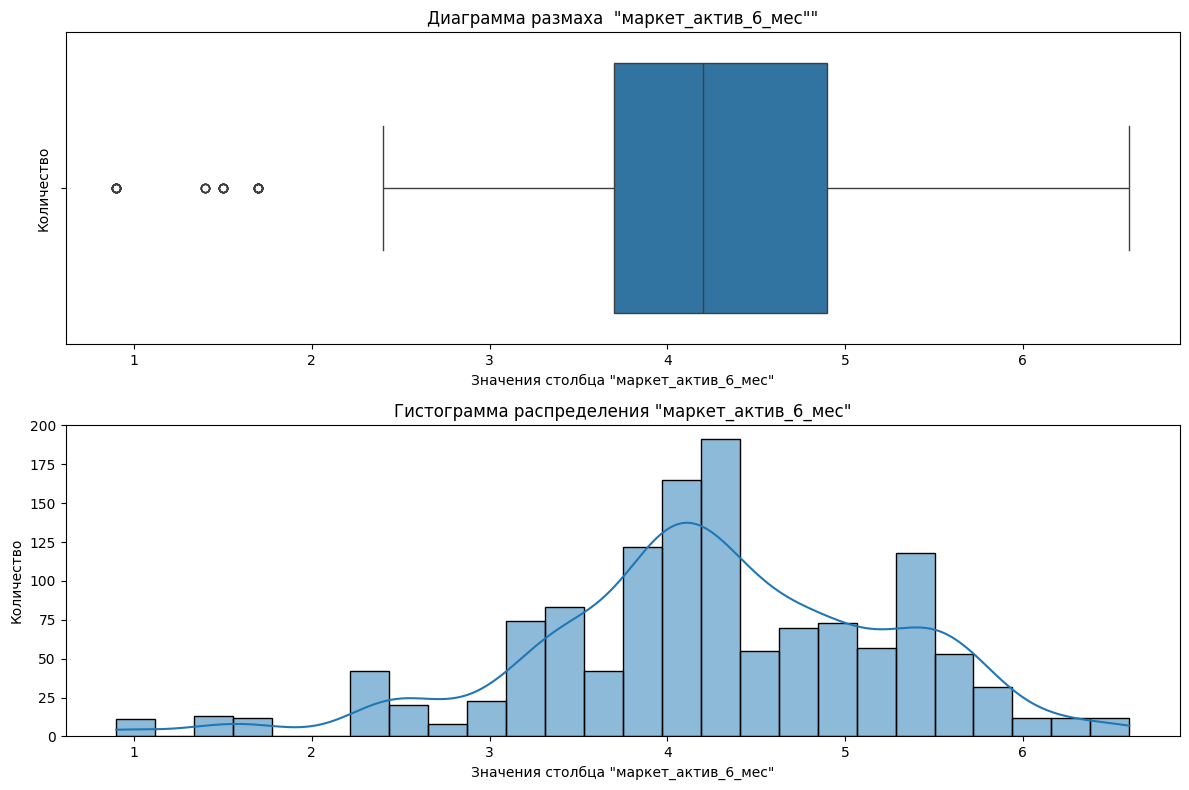

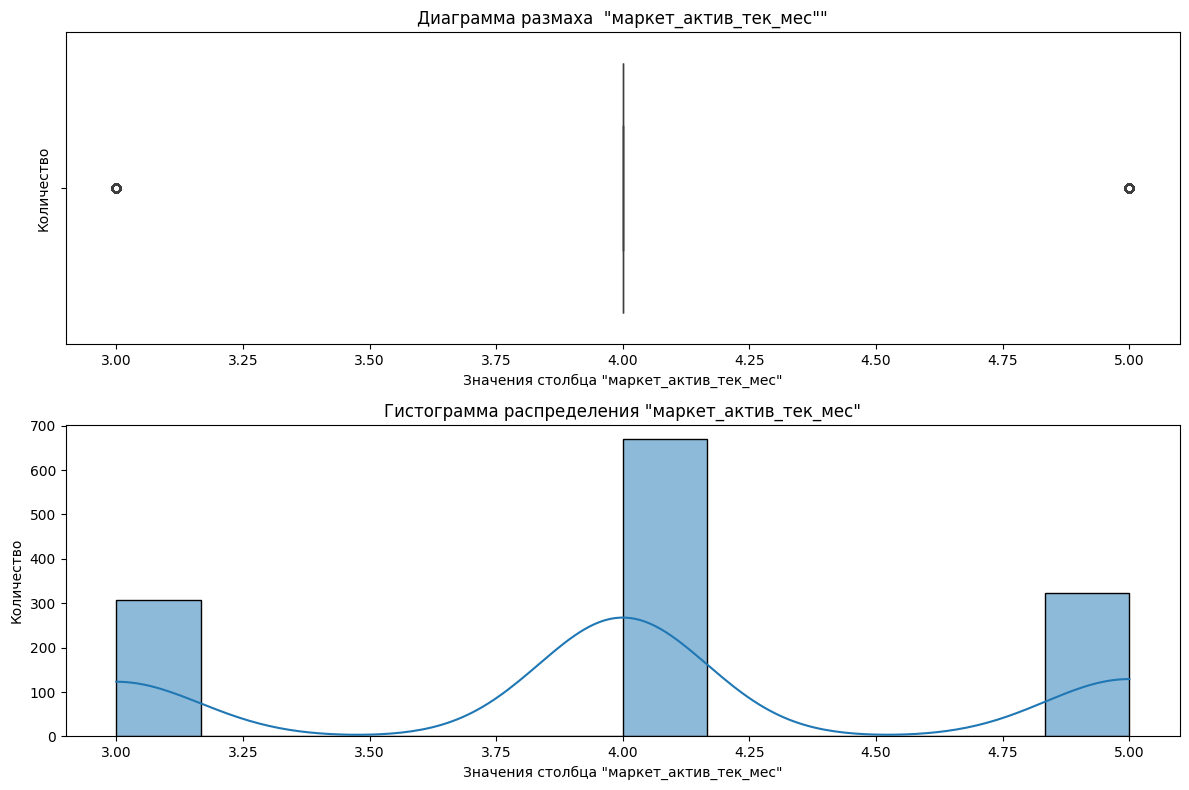

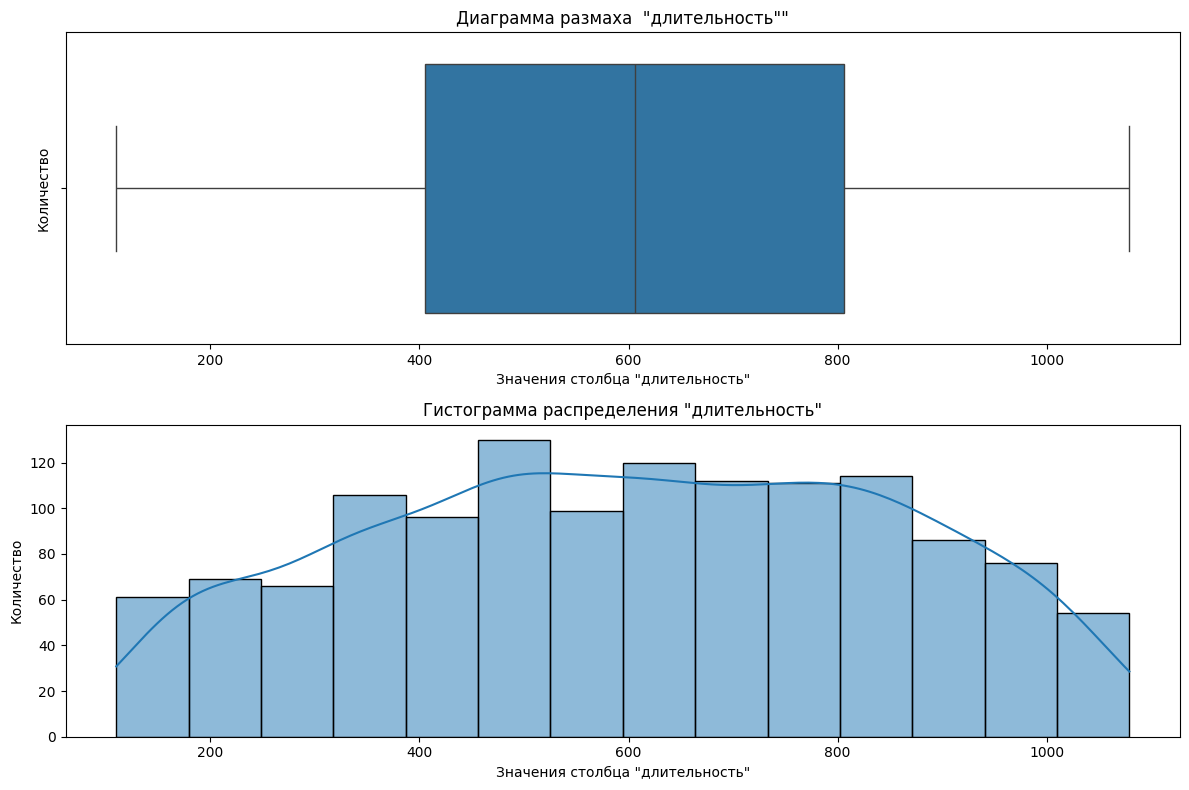

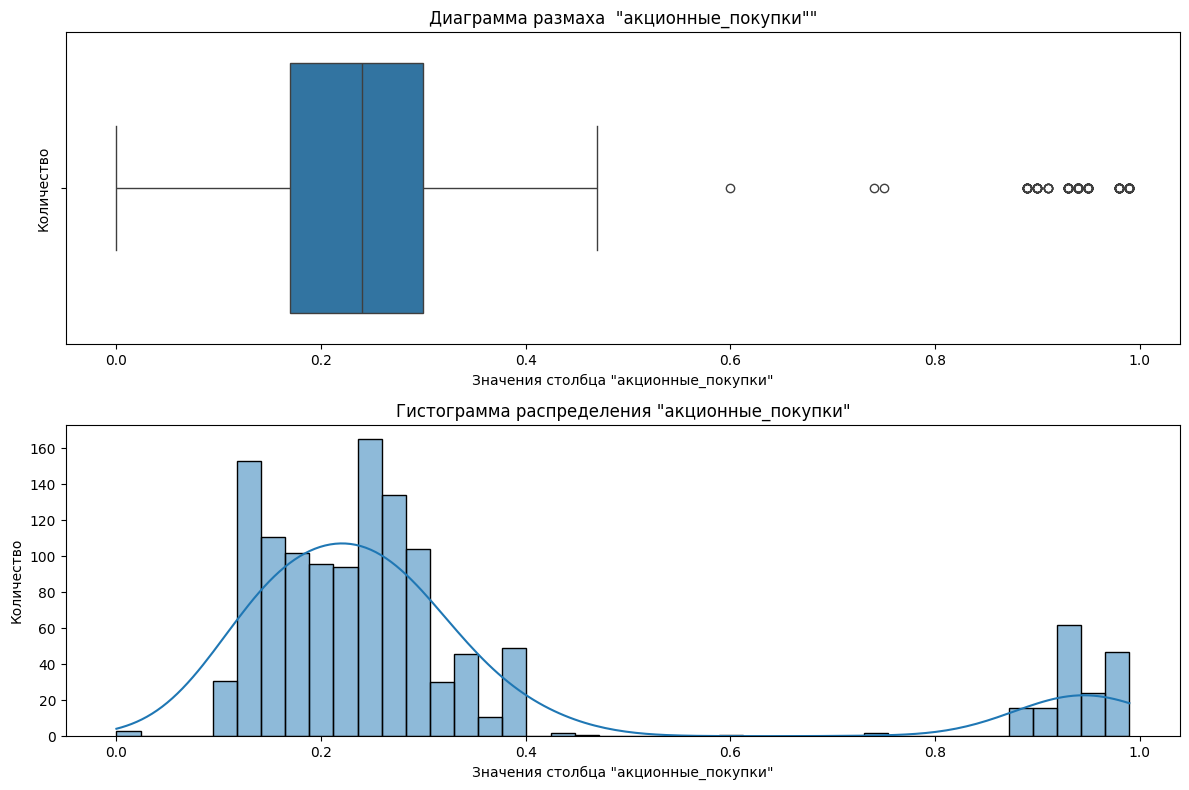

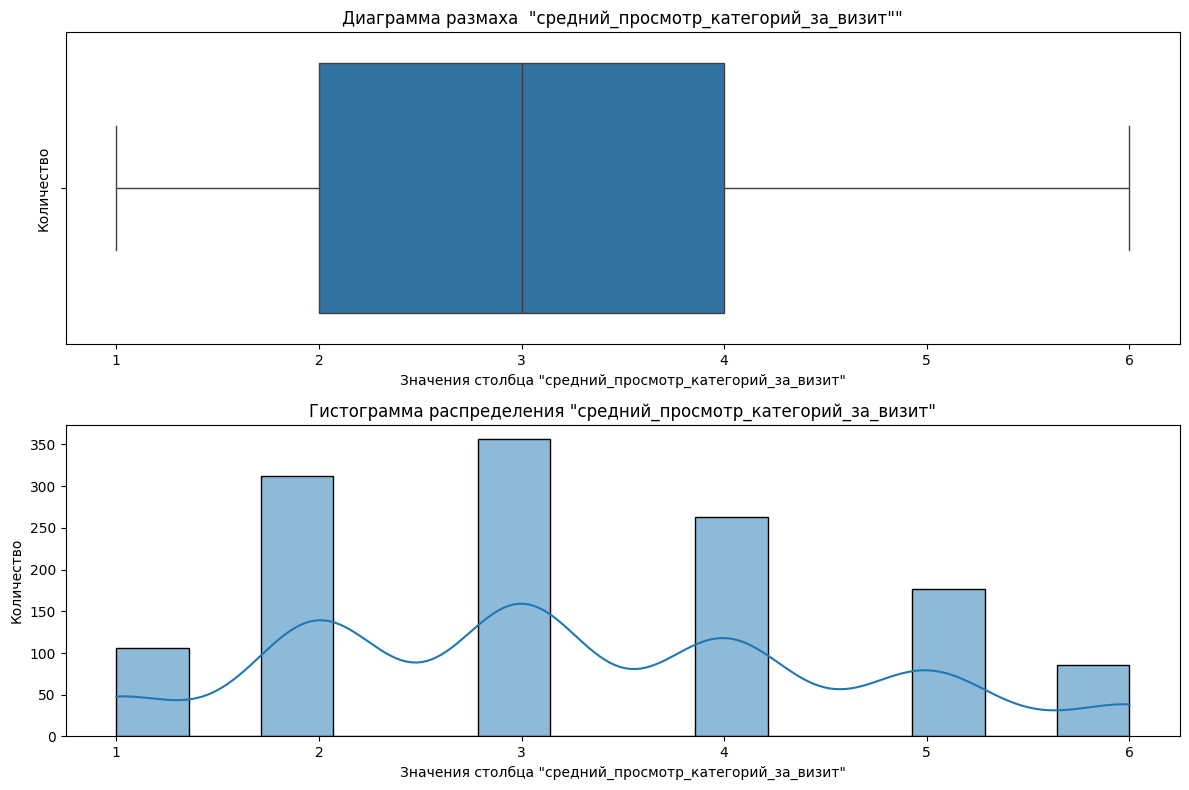

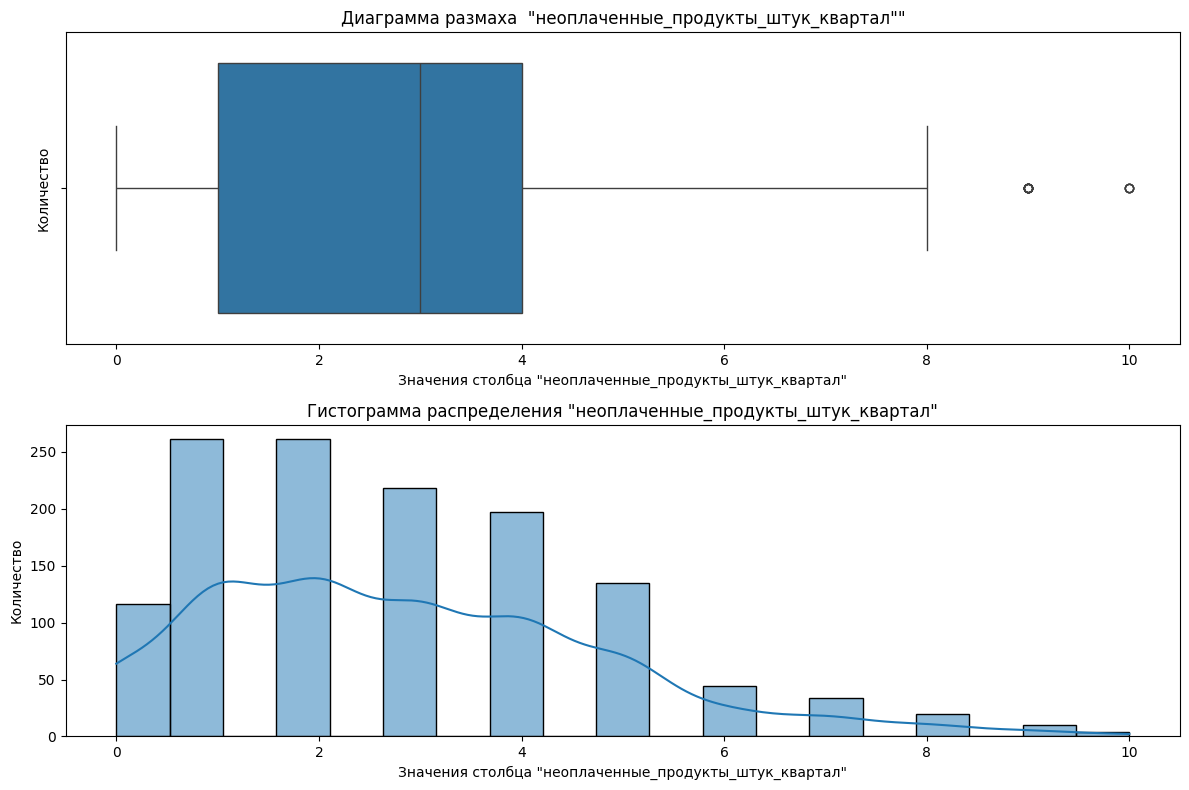

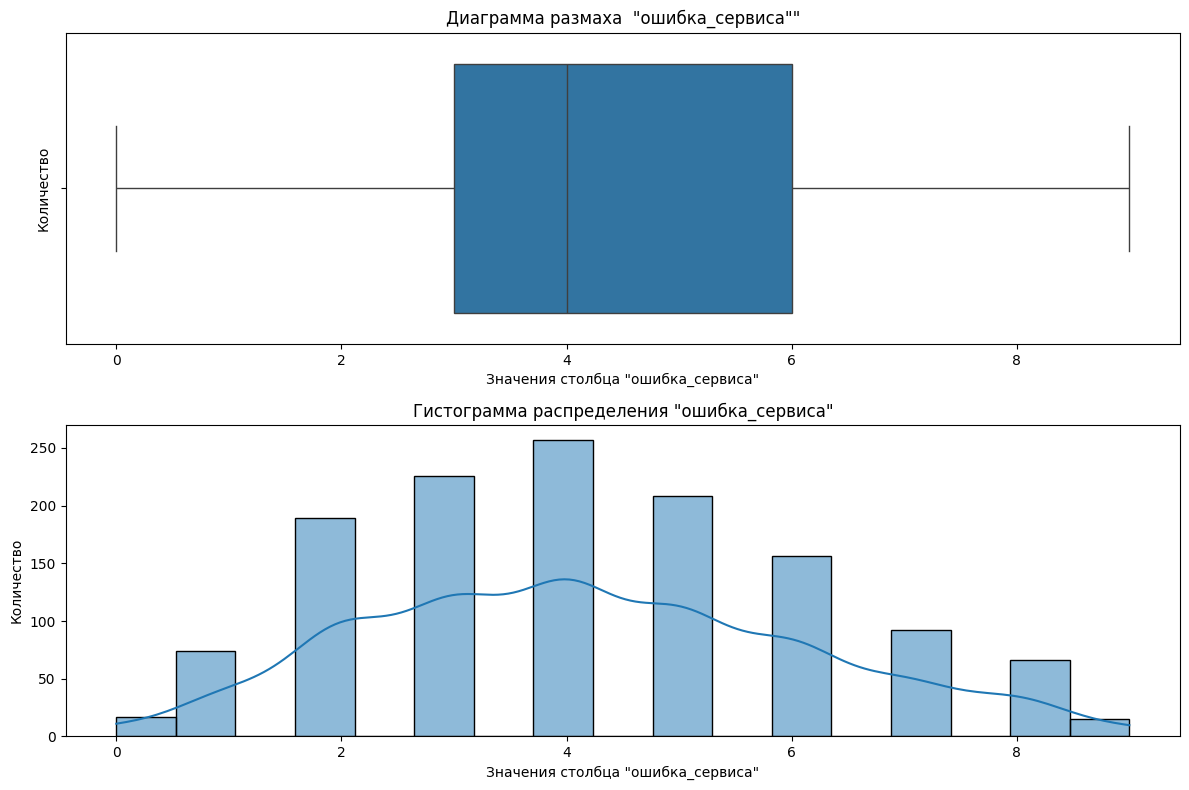

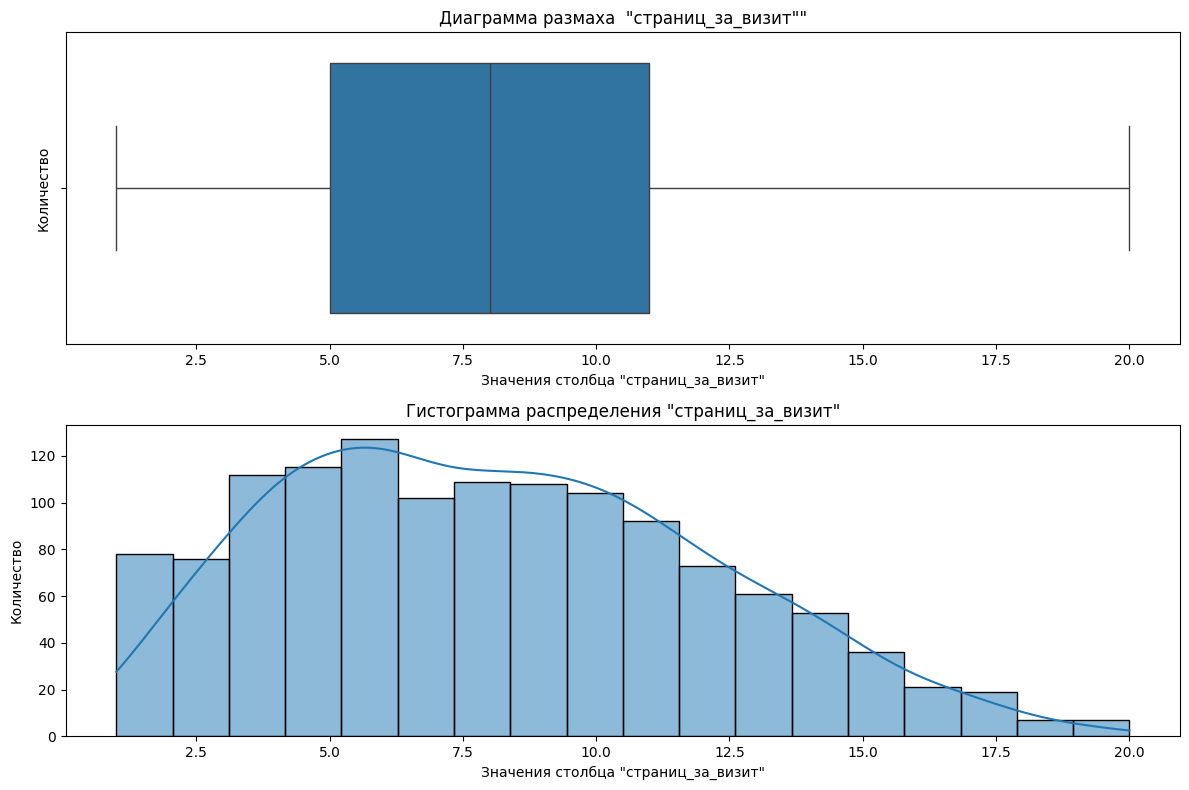

In [36]:
#Выберем все числовые признаки
num_col_market_file = ['маркет_актив_6_мес', 
                  'маркет_актив_тек_мес', 
                  'длительность', 
                  'акционные_покупки',
                  'средний_просмотр_категорий_за_визит',
                  'неоплаченные_продукты_штук_квартал', 
                  'ошибка_сервиса', 
                  'страниц_за_визит']

# Построим гистограммы и boxplot для визуализации распределения данных для каждого числового признака

for col in num_col_market_file:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # первый график (boxplot)
    sns.boxplot(x=market_file[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Диаграмма размаха  "{col}""')
    
    plt.subplot(2, 1, 2)  # второй график (гистограмма)
    sns.histplot(market_file[col], kde=True)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()



Маркет_актив_6_мес -  распределен не совсем нормально, присутсвует ассиметрия. есть несколько выбросов (слишком маленькие значения. При среднем значении 4,2 маркетинговых коммуникаций в месяц, минимальное значение данного показателя меньше 1.


Маркет_актив_тек_мес -  есть 3 четкий пика, этот признак - кандидат на перевод в категориальную шкалу из 3 категорий (3/4/5 коммуникай за месяц)


Длительность - распределение близко к нормальному на всем диапазоне значений, выбросов нет

Акционные_покупки -  имеет бимодальное распределение, пик около 0,3 - типичный клиент покупает 30 % по акции, а также около 1 - есть определенная доля покупателей, покупающих только по акции. 

Средний_просмотр_категорий_за_визит - нормальное распределение с небольшим смещением вправо от 1 до 6, в среднем клиент просматривает 3 категории за визит. имеет нормальное распределение. Этот признак - тоже кандидат на перевод в категориальную шкалу из 6 категорий

Неоплаченные_продукты_штук_квартал - распределение сильно скошено вправо, среднее значение неоплаченных товаров в корзине 2.8, но есть и клиенты у которых в корзине хранится по 10 неоплаченных товаров.

Ошибка_сервиса - в целом распределен нормально, есть небольшая скошенность вправо.  В среднем пользователи сталкиваюся с техническими ошибками на сайте - 4 раза за время посещения.

Страниц_за_визит -  нормальное распределение с небольшим смещением вправо. В среднем за визит пользователь просматривает 8 стрниц, но есть и те кто смотрит только одну страницу или наоборот около 20.

**Датасет market_money**

In [37]:
market_money.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


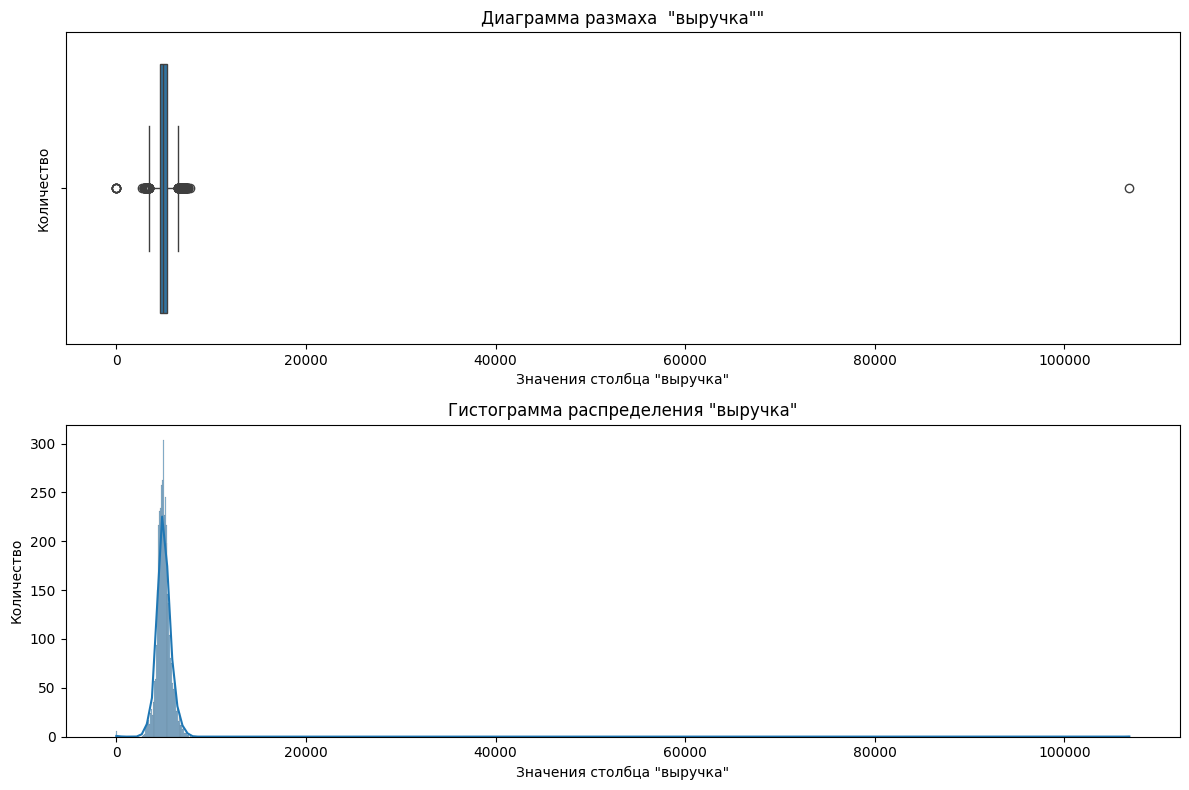

In [38]:
#Выберем все числовые признаки
num_col_market_money = ['выручка']

# Построим гистограмму и boxplot для визуализации распределения данных

for col in num_col_market_money:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # первый график (boxplot)
    sns.boxplot(x=market_money[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Диаграмма размаха  "{col}""')
    
    plt.subplot(2, 1, 2)  # второй график (гистограмма)
    sns.histplot(market_money[col], kde=True)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()


In [39]:
market_money[market_money['выручка']==market_money['выручка'].max()]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Описательная статистика и визуализация показывают наличие выброса более 100 тыс, пр среднем значении 5025. Избавимся от аномального значения

In [40]:
market_money = market_money[market_money['выручка'] < 100000]

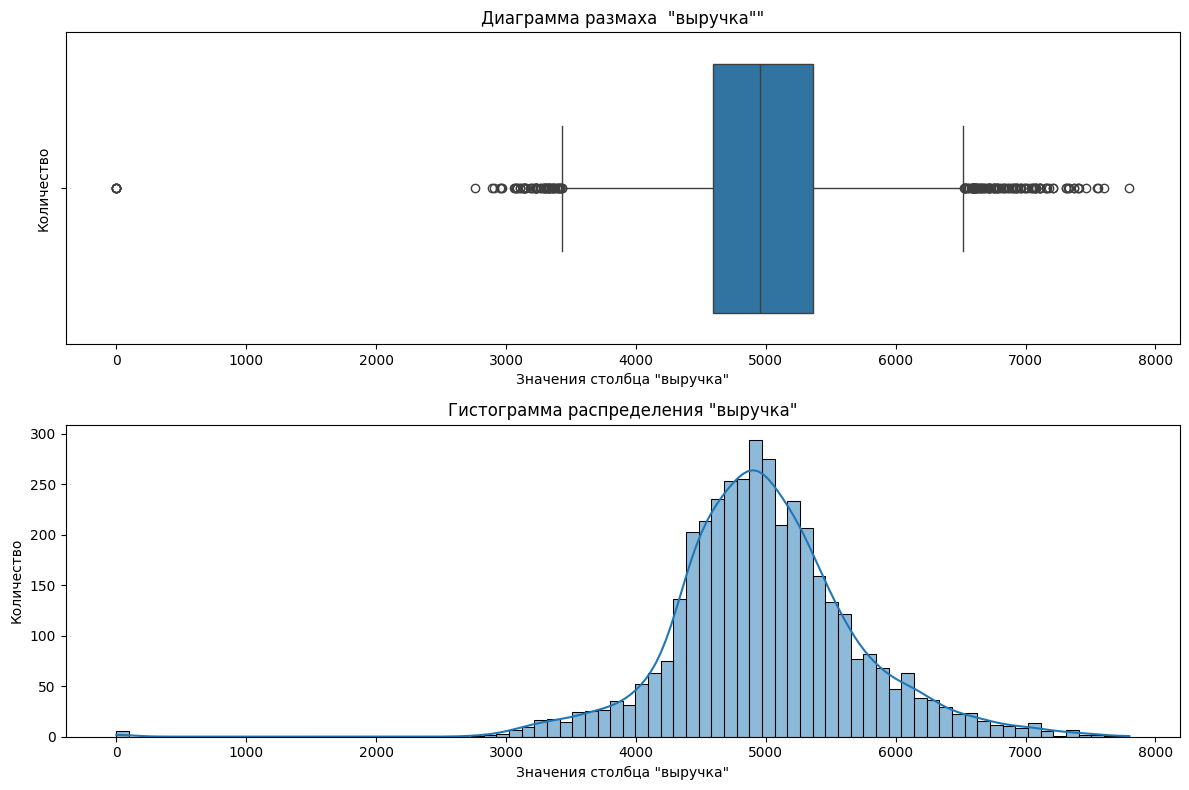

In [41]:
# Построим визуализацию без аномального значения

for col in num_col_market_money:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # первый график (boxplot)
    sns.boxplot(x=market_money[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Диаграмма размаха  "{col}""')
    
    plt.subplot(2, 1, 2)  # второй график (гистограмма)
    sns.histplot(market_money[col], kde=True)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()

Признак выручка распределен нормально, но имеются нулевые значения - это пользователи, которые не совершали покупок в указанные периоды. Мы хотим в дальнейшем использовать только тех пользователей, у которых есть активность за три месяца, поэтому от нулевых значений тоже предлагаю избавиться. Сделаю это чуть позже, когда будем формировать список клиентов  с покупательской активностью не менее трёх месяцев

**Датасет market_time**

In [42]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


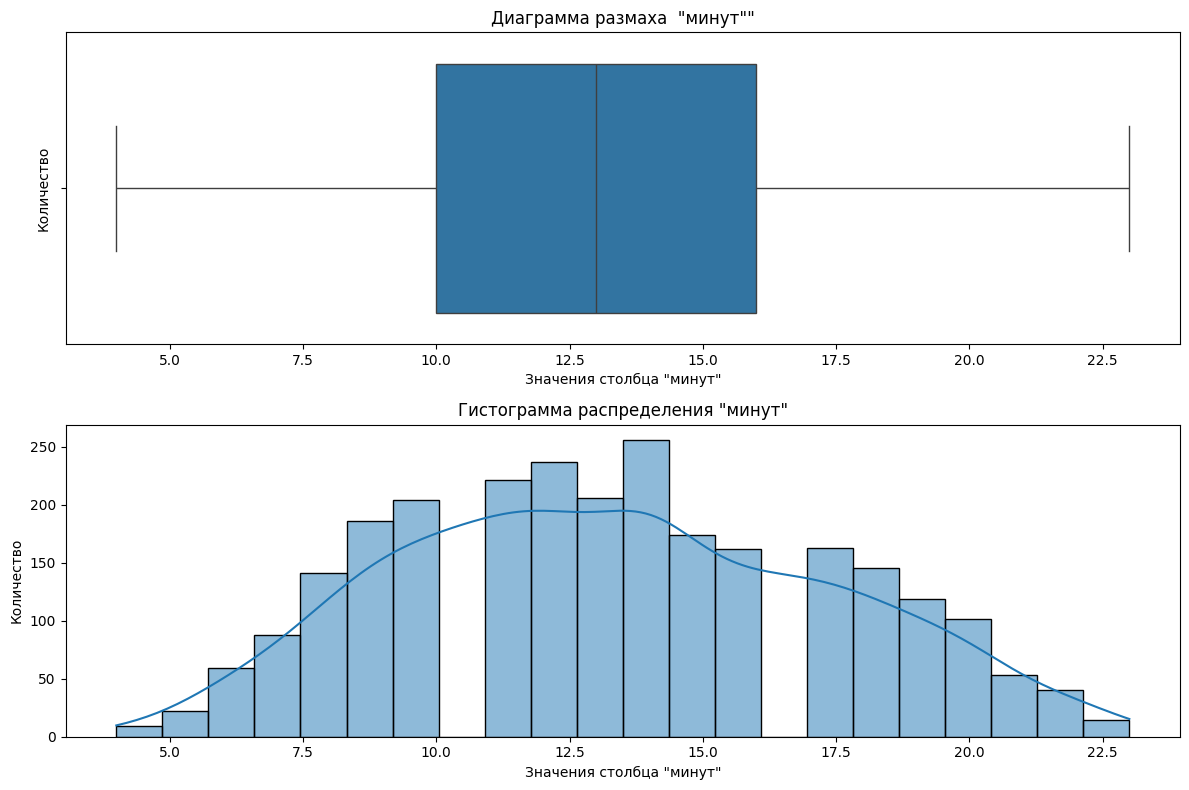

In [43]:
#Выберем все числовые признаки
num_col_market_time = ['минут']

# Построим гистограмму и boxplot для визуализации распределения данных

for col in num_col_market_time:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # первый график (boxplot)
    sns.boxplot(x=market_time[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Диаграмма размаха  "{col}""')
    
    plt.subplot(2, 1, 2)  # второй график (гистограмма)
    sns.histplot(market_time[col], kde=True)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()


Признак "минут" распределен нормально, в среднем покупатель проводит на сайте 13 минут

**Датасет money**

In [44]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


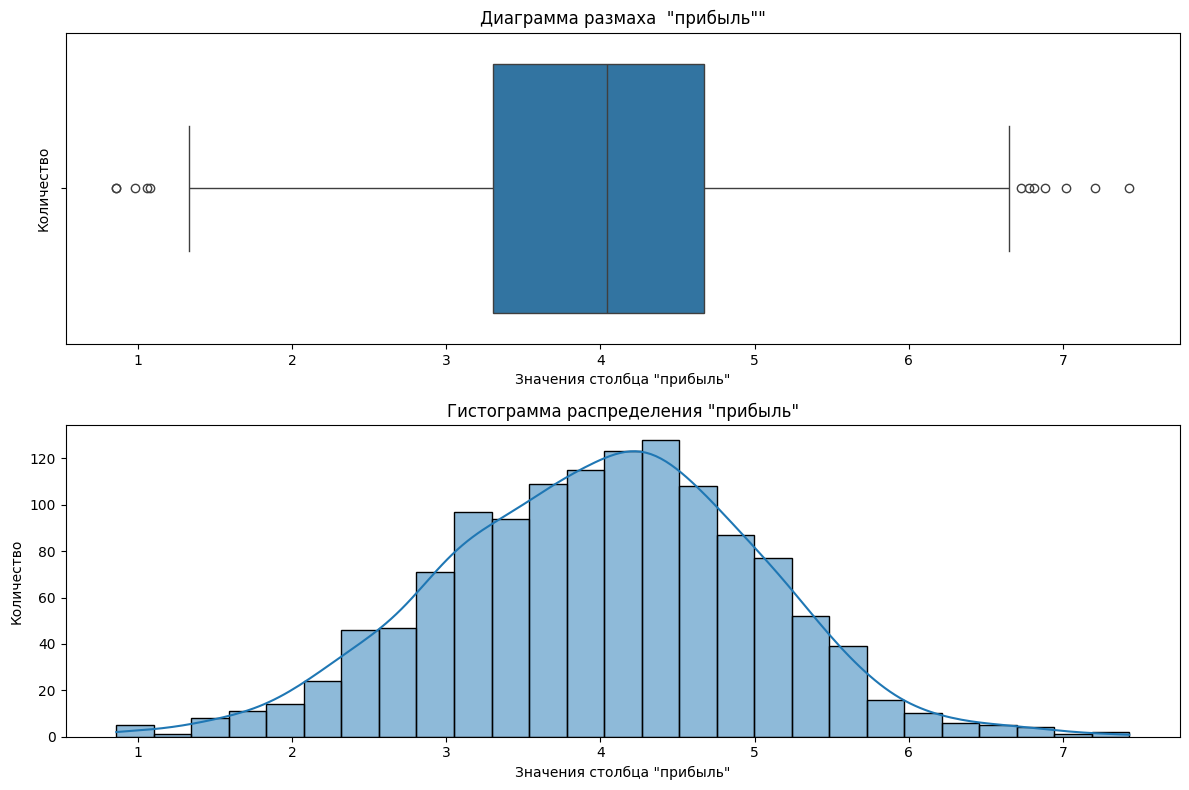

In [45]:
#Выберем все числовые признаки
num_col_money = ['прибыль']

# Построим гистограмму и boxplot для визуализации распределения данных

for col in num_col_money:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # первый график (boxplot)
    sns.boxplot(x=money[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Диаграмма размаха  "{col}""')
    
    plt.subplot(2, 1, 2)  # второй график (гистограмма)
    sns.histplot(money[col], kde=True)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()


Значения признака "прибыль" распределены нормально. В среднем 4000 получает магазин от продаж каждому покупателю

**Отберем клиентов с покупательской активностью не менее трёх месяцев**, то есть таких, которые что-либо покупали в этот период.

In [46]:
market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [47]:
#удаляем из всех датасетов пользователей, которые не совершали покупок за последние 3 месяца и клиента с id 215380 с аномально большим значением (он удален у нас только в market_money)    

market_file = market_file.query('id != [215348, 215357, 215359, 215380]')
market_money = market_money.query('id != [215348, 215357, 215359, 215380]')
market_time = market_time.query('id != [215348, 215357, 215359, 215380]')
money = money.query('id != [215348, 215357, 215359, 215380]')

Для **категориальных данных** смотрим сводную статистику и построим круговые диаграммы распределения

In [48]:
market_file.describe(include='object')

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1296,1296,1296,1296
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,922,959,329


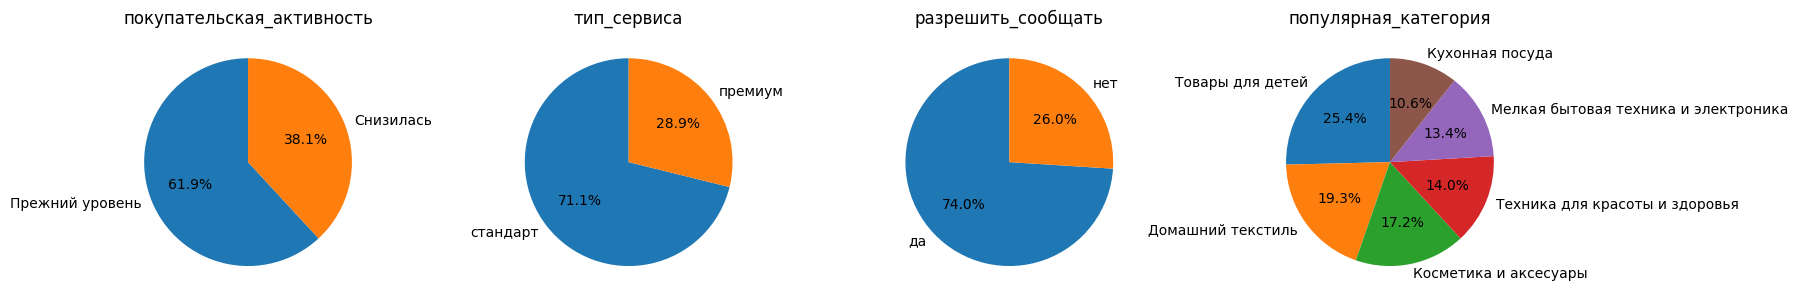

In [49]:
#создаем список категориальных признаков датасета market_file
cat_col_market_file = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

#функция для построения круговых диаграмм

def plot_pie(data, column, position, total_plots):
    plt.subplot(1, total_plots, position)
    data[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(column)
    plt.ylabel('')  

plt.figure(figsize=(18, 10))

#строим круговые диаграммы для каждого признака
for i, col in enumerate(cat_col_market_file, 1):
    plot_pie(market_file, col, i, len(cat_col_market_file))

plt.tight_layout()  
plt.show()

Покупательская активность - 61,8% занимает прежний уровень и 38,2 % снизилась. Действительно самое время задуматься о новой стратегии повышения покупательской активности

Тип сервиса - преобладает стандарт - 71,1%,премиум клиентов значительно меньше - только 28,9 %

73,9 % попкупателей не против того, чтобы им сообщали предложения о товарах

Самыми популярными категориями являются товары для детей, домашний текстиль и косметика и аксессуары.

Вцелом ничего необычного в данных нет

In [50]:
market_money.describe(include='object')

,период
count,3888
unique,3
top,препредыдущий_месяц
freq,1296


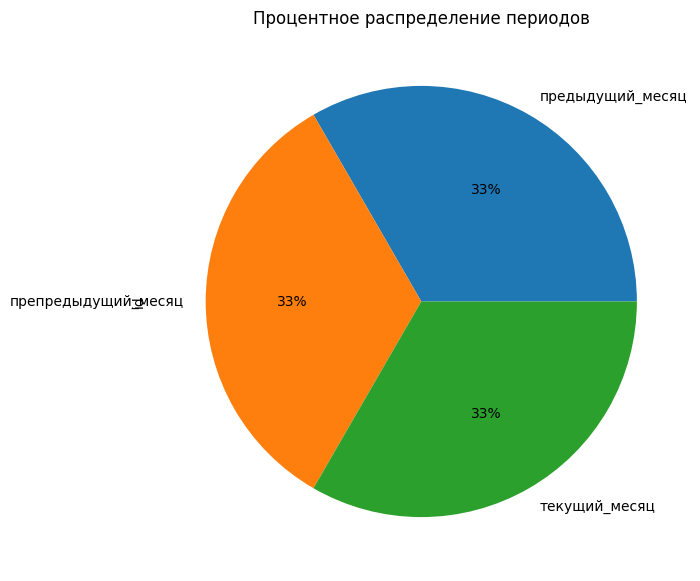

In [51]:
(
market_money
    .pivot_table(index='период',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), legend=False)
)
plt.title('Процентное распределение периодов')
plt.show()

Выручка равномерно распределена в каждом периоде

In [52]:
market_time.describe(include='object')

,период
count,2592
unique,2
top,текущий_месяц
freq,1296


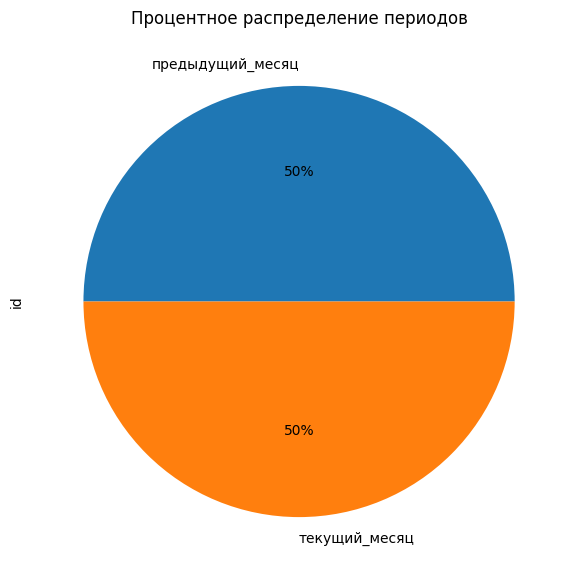

In [53]:
(
market_time
    .pivot_table(index='период',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), legend=False)
)
plt.title('Процентное распределение периодов')
plt.show()

Признак распределен равномерно - покупатели проводили на сайте одинаковое количество времени за представленные периоды


На данном этапе был проведен исследовательский анализ данных из каждой таблицы. 

Изучены все количественные и категориальные признаки,выявлены несколько аномальных значений, которые было принято решение отбросить из рассмотрения. В целом данные выглядят полными и нормальными, достаточными для дальнейшего анализа.

Отобраны клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период.

## Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv. 

Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [54]:
# добавляем в market_money отдельные столбцы для каждого периода
money_pivot = market_money.pivot(
    index='id',
    columns='период',
    values='выручка'
).add_prefix('выручка_').reset_index()

# добавляем в market_time отдельные столбцы для каждого периода
time_pivot = market_time.pivot(
    index='id',
    columns='период',
    values='минут'
).add_prefix('время_').reset_index()

# объединяем все таблицы 
final_data = (
    market_file
    .merge(money_pivot, on='id', how='left') 
    .merge(time_pivot, on='id', how='left')  
)

# итоговая таблица
final_data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [55]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

Все данные объединены в одной таблице в полном объеме, без потерь, она содержит 1297 строк, 18 колонок. Переходим к корреляционному анализу

In [56]:
final_data.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между всеми количественными признаками методом Пирсона

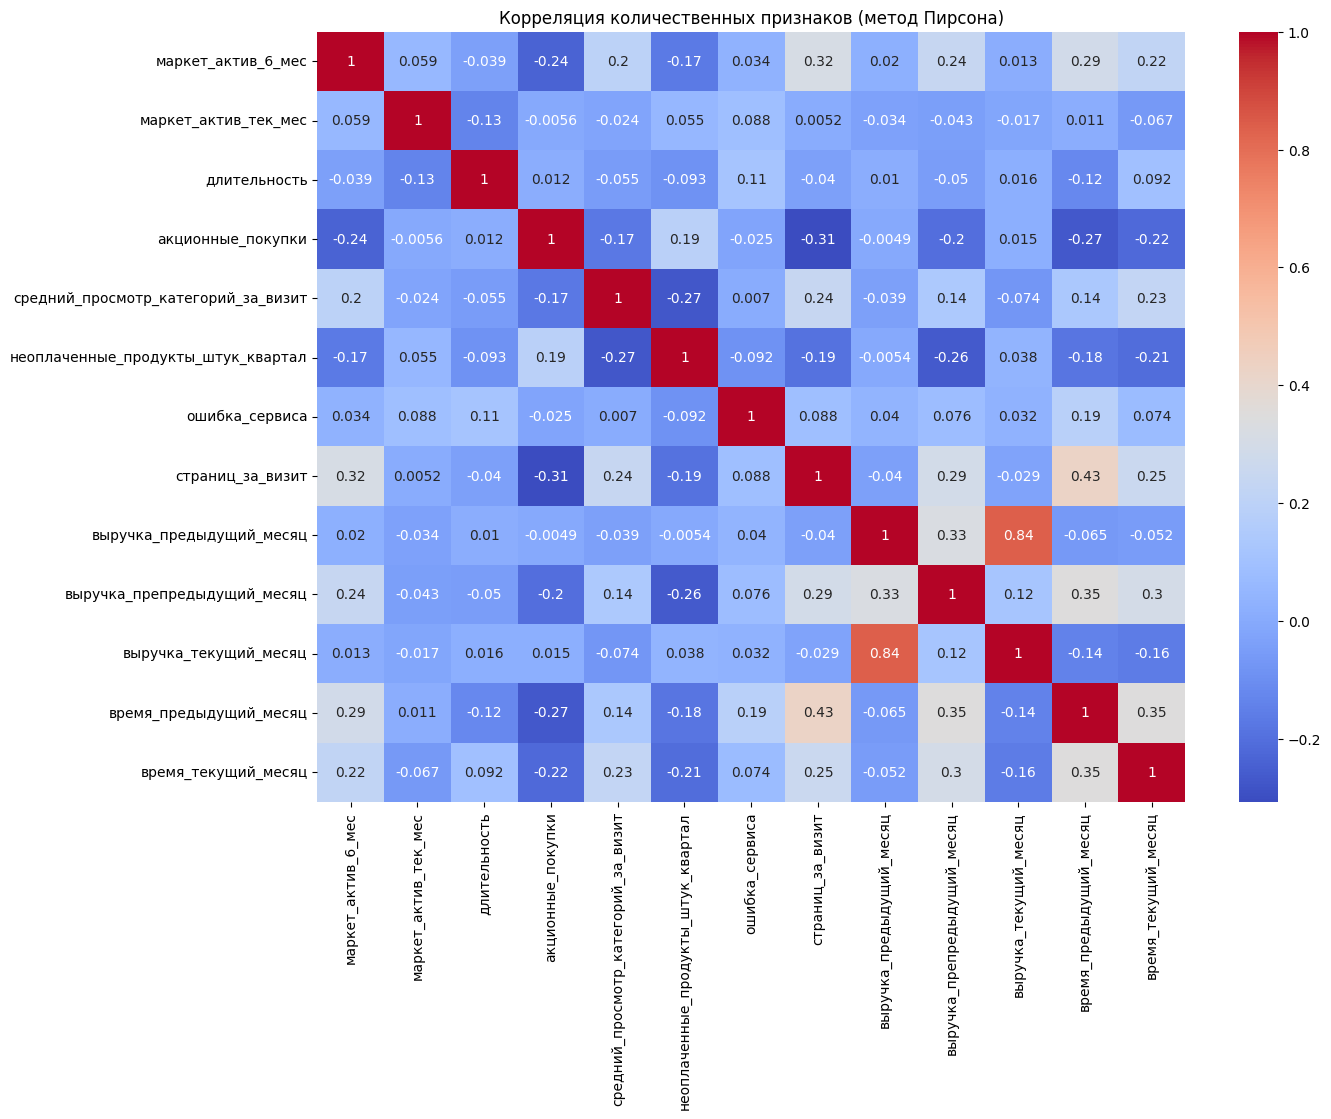

In [57]:
# Расчет корреляции Пирсона

num_col = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'время_предыдущий_месяц',
    'время_текущий_месяц'
]
corr_matrix = final_data[num_col].corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция количественных признаков (метод Пирсона)')
plt.show()

Корреляция Пирсона количественных значений по шкале Чеддока указывает на:
- наличие связи только между признаками 'выручка_текущий_месяц' и 'время_предыдущий_месяц' = 0,84

- между входными параметрами отсутствует связь выше 0,9 следовательно мультиколлинеарность отсутсвует и учитывать ее при обучении модели не нужно

## Использование пайплайнов

На данном этапе мы будем применять все изученные модели. Для этого используем пайплайны.

In [58]:
#Преобразуем целевой признак в числовой формат (0 — прежний уровень, 1 — снизилась)
final_data['покупательская_активность'] = final_data['покупательская_активность'].map({'Прежний уровень': 0, 'Снизилась': 1})

# Делим данные на признаки (X) и целевой признак (y)
X = final_data.drop(columns=['id', 'покупательская_активность'])
y = final_data['покупательская_активность']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Создание ColumnTransformer с двумя кодировщиками и двумя скейлерами

In [59]:
# Категориальные признаки
cat_features_onehot = ['популярная_категория']
cat_features_ordinal = ['тип_сервиса', 'разрешить_сообщать']

# Числовые признаки
num_features_minmax = ['маркет_актив_6_мес', 'акционные_покупки']
num_features_standard = [
    'длительность',
    'страниц_за_визит',
    'ошибка_сервиса',
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'время_предыдущий_месяц',
    'время_текущий_месяц'
]

# Создаём трансформер
preprocessor = ColumnTransformer(transformers=[
    ('num_std', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_features_standard),

    ('num_minmax', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), num_features_minmax),

    ('cat_ohe', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features_onehot),

    ('cat_ord', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ]), cat_features_ordinal)
])

Далее обучим 4 модели, для оценки качества будем использовать F1-меру, по следующим причинам:

    • Метрика accuracy может быть вводящей в заблуждение из-за перекоса в классах (у нас есть небольшой дисбаланс : прежний уровень - около 62%, снизилась - 38%)
	•	Метрики precision и recall по отдельности не дают полной картины.
	•	F1-мера — оптимальный выбор для оценки моделей в задачах с умеренно несбалансированными классами и при важности обоих типов ошибок
	•	В данном проекте это поможет точно предсказывать, какие клиенты теряют интерес, чтобы правильно персонализировать предложения

In [60]:
#Обучение моделей
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'SVC': SVC(random_state=42)
}

from sklearn.model_selection import cross_val_score

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    results[name] = scores.mean()
    print(f'{name} — средняя F1 (кросс-валидация): {scores.mean():.3f}')

KNN — средняя F1 (кросс-валидация): 0.797
LogisticRegression — средняя F1 (кросс-валидация): 0.802
DecisionTree — средняя F1 (кросс-валидация): 0.774
SVC — средняя F1 (кросс-валидация): 0.823


Займемся выбором лучшей модели, используя заданную метрику. Для этого я выбрала первую стратегию:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно.


**LogisticRegression**

In [61]:
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, scoring='f1', cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['длительность',
                                                                          'страниц_за_визит',
                                                                          'ошибка_сервиса',
                                                                          'маркет_актив_тек_мес',
                                                                          'средний_просмотр_категорий_за_визит',
                                                                          'неоплаченные_продукты_штук_квартал',
                                                                          'выручка_предыдущий_мес...
                                                                         ['популярная_категория']),
                                                                        ('cat_ord',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['lbfgs']},
             scoring='f1')

In [62]:
print("Лучшие параметры:", grid_lr.best_params_)
print("Лучшая F1-мера (по кросс-валидации):", round(grid_lr.best_score_, 3))

Лучшие параметры: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Лучшая F1-мера (по кросс-валидации): 0.812


	Лучшие параметры: C=0.01, penalty='l2', solver='lbfgs'
	Лучшая F1-мера (по кросс-валидации): 0.812

Модель показала хороший результат при слабой настройке на точность (C = 0.01) и использовании стандартной регуляризации (L2).
Она делает предсказания достаточно точно и устойчиво, а также проста в использовании и понимании.
Эта модель хорошо подходит, когда важно интерпретировать результат — например, понять, какие признаки больше влияют на снижение активности.

In [63]:
pipe_lr_no_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=1000, penalty='l2', solver='lbfgs', random_state=42, max_iter=1000))
])

scores = cross_val_score(pipe_lr_no_reg, X_train, y_train, cv=5, scoring='f1')
print(f'F1-мера без регуляризации: {scores.mean():.3f}')

F1-мера без регуляризации: 0.797


Исследована логистическая регрессия без регуляризации (C=1000). Модель показала худшее качество — переобучается, результат хуже.

**KNeighborsClassifier**

In [64]:
pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, scoring='f1', cv=5)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['длительность',
                                                                          'страниц_за_визит',
                                                                          'ошибка_сервиса',
                                                                          'маркет_актив_тек_мес',
                                                                          'средний_просмотр_категорий_за_визит',
                                                                          'неоплаченные_продукты_штук_квартал',
                                                                          'выручка_предыдущий_мес...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['популярная_категория']),
                                                                        ('cat_ord',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 5, 7],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1')

In [65]:
print("Лучшие параметры:", grid_knn.best_params_)
print("Лучшая F1-мера (по кросс-валидации):", round(grid_knn.best_score_, 3))

Лучшие параметры: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance'}
Лучшая F1-мера (по кросс-валидации): 0.834


    Лучшие параметры: 'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance'
	Лучшая F1-мера (по кросс-валидации): 0.834

Лучший результат модель показала при использовании 7 ближайших соседей и учёте расстояния до них (чем ближе — тем важнее).
Также она работала лучше при метрике расстояния «по прямым линиям» (манхэттенская, p = 1).
Эта модель хорошо справляется находить клиентов, похожих на тех, кто уже снижал активность.

**DecisionTreeClassifier**

In [66]:
pipe_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


param_grid_tree = {
    'classifier__max_depth': [3, 5, 10],             
    'classifier__min_samples_split': [2, 5, 10],     
    'classifier__criterion': ['gini', 'entropy']     
}

grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid_tree, scoring='f1', cv=5)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['длительность',
                                                                          'страниц_за_визит',
                                                                          'ошибка_сервиса',
                                                                          'маркет_актив_тек_мес',
                                                                          'средний_просмотр_категорий_за_визит',
                                                                          'неоплаченные_продукты_штук_квартал',
                                                                          'выручка_предыдущий_мес...
                                                                        ('cat_ord',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [67]:
print("Лучшие параметры:", grid_tree.best_params_)
print("Лучшая F1-мера (по кросс-валидации):", round(grid_tree.best_score_, 3))

Лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Лучшая F1-мера (по кросс-валидации): 0.775


	Лучшие параметры: 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 5
	Лучшая F1-мера (по кросс-валидации): 0.775

Оптимальные параметры для дерева: глубина 5 и минимальное количество клиентов в разбиении — 5.
Модель легко понять, она строит понятные правила (например: если клиент тратит меньше и не смотрит товары — активность снизится).
Но дерево склонно к упрощению и может упускать важные связи, из-за чего его точность немного ниже.

**SVC**

In [68]:
pipe_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42,  probability=True))
])

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],               
    'classifier__kernel': ['linear', 'rbf'],     
    'classifier__gamma': ['scale', 'auto']       
}

grid_svc = GridSearchCV(pipe_svc, param_grid=param_grid_svc, scoring='f1', cv=5)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['длительность',
                                                                          'страниц_за_визит',
                                                                          'ошибка_сервиса',
                                                                          'маркет_актив_тек_мес',
                                                                          'средний_просмотр_категорий_за_визит',
                                                                          'неоплаченные_продукты_штук_квартал',
                                                                          'выручка_предыдущий_мес...
                                                                         ['популярная_категория']),
                                                                        ('cat_ord',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать'])])),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1')

In [69]:
print("Лучшие параметры:", grid_svc.best_params_)
print("Лучшая F1-мера (по кросс-валидации):", round(grid_svc.best_score_, 3))

Лучшие параметры: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Лучшая F1-мера (по кросс-валидации): 0.823


	Лучшие параметры: 'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'
	Лучшая F1-мера (по кросс-валидации): 0.823

Эта модель показала хороший результат при использовании сложного ядра (rbf), которое позволяет учитывать нелинейные связи между признаками.
Она хорошо различает тех клиентов, чья активность может снизиться, даже если связи между признаками неочевидны.
Модель работает немного дольше и сложнее для понимания, но делает довольно точные предсказания.

На данном этапе были обучены четыре разные модели, чтобы предсказывать, снизится ли покупательская активность клиента.  
Для оценки качества моделей использовали метрику F1-мера, потому что:

- у нас есть небольшой дисбаланс классов;
- важно как находить нужных клиентов, так и не ошибаться;
- F1 учитывает сразу и точность (precision), и полноту (recall).

Сначала были обучены базовые версии моделей, затем — выполнен подбор лучших гиперпараметров с помощью `GridSearchCV`.  
Вот результаты по итогам подбора:

- **KNeighborsClassifier** — *F1-мера: 0.834*  
  Лучшие параметры: `n_neighbors=7`, `weights='distance'`, `p=1`.  
  Модель хорошо работает, когда нужно находить похожих клиентов. Это оказался **наиболее точный вариант**.

- **SVC (метод опорных векторов)** — *F1-мера: 0.823*  
  Параметры: `C=1`, `kernel='rbf'`, `gamma='scale'`.  
  Модель хорошо различает классы даже при сложных зависимостях, но более ресурсоёмкая и сложнее для объяснения. Результат показала тоже очень хороший.

- **LogisticRegression** — *F1-мера: 0.812*  
  Параметры: `C=10`, `penalty='l2'`, `solver='lbfgs'`.  
  Простая и понятная модель. Даёт стабильные результаты, хорошо подходит, когда важно интерпретировать влияние признаков.

- **DecisionTreeClassifier** — *F1-мера: 0.775*  
  Параметры: `max_depth=5`, `min_samples_split=5`, `criterion='gini'`.  
  Легко интерпретируется, но уступает по качеству другим моделям.


Лучшей моделью оказалась **KNeighborsClassifier**, но для оценки важности признаков и построения графика с помощью метода SHAP я решила использовать модель SVC (метод опорных векторов) по ряду причин:

- Модель KNeighborsClassifier показала чуть лучшее качество (F1-мера: 0.834), но она не поддерживает оценку важности признаков — SHAP с ней работает плохо или не работает вообще.
- Модель SVC дала очень близкий результат (F1-мера: 0.823) и при этом совместима с SHAP.
- Разница в качестве между моделями минимальна (всего 0.011), поэтому принято решение **использовать SVC для анализа**.


In [70]:
# Осталось проверить работу модели с лучшими параметрами на тестовой выборке, чтобы убедиться что модель не переобучена и хорошо справляется с новой выборкой
#best_svc = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('classifier', SVC(C=1, kernel='rbf', gamma='scale', probability=True, random_state=42))
#])

# Обучение модели на обучающей выборке
#best_svc.fit(X_train, y_train)

# Предсказания и расчет метрики на тестовой выборке
#y_pred_svc = best_svc.predict(X_test)

#f1_test = f1_score(y_test, y_pred_svc)
#print(f"F1-мера на тестовой выборке (SVC): {f1_test:.3f}")


In [71]:
# Осталось проверить работу модели с лучшими параметрами на тестовой выборке, чтобы убедиться что модель не переобучена и хорошо справляется с новой выборкой


y_pred_svc = grid_svc.best_estimator_.predict(X_test)

f1_test = f1_score(y_test, y_pred_svc)
print(f"F1-мера на тестовой выборке (SVC): {f1_test:.3f}")


F1-мера на тестовой выборке (SVC): 0.870


Модель показала F1 = 0.870 на тестовой выборке, что подтверждает её устойчивость и хорошее качество. 
Можем переходить к оценке важности признаков для данной модели

## Анализ важности признаков

In [72]:
# Получаем лучшую модель из GridSearchCV
best_svc = grid_svc.best_estimator_

# Получаем имена признаков после OneHot-кодирования
cat_ohe_names = best_svc.named_steps['preprocessor'] \
    .named_transformers_['cat_ohe'] \
    .named_steps['encoder'] \
    .get_feature_names_out(['популярная_категория'])

# Собираем полный список имён признаков
feature_names = (
    num_features_standard +
    num_features_minmax +
    list(cat_ohe_names) +
    cat_features_ordinal
)

# Трансформация признаков
X_transformed = best_svc.named_steps['preprocessor'].transform(X_train)

# Выбираем часть выборки для SHAP
X_sample = shap.sample(X_transformed, 100, random_state=42)

# Функция предсказания вероятности
def model_predict(X):
    return best_svc.named_steps['classifier'].predict_proba(X)[:, 1]

# Запуск KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_sample)
shap_values = explainer.shap_values(X_sample)

100%|██████████| 100/100 [07:47<00:00,  4.68s/it]


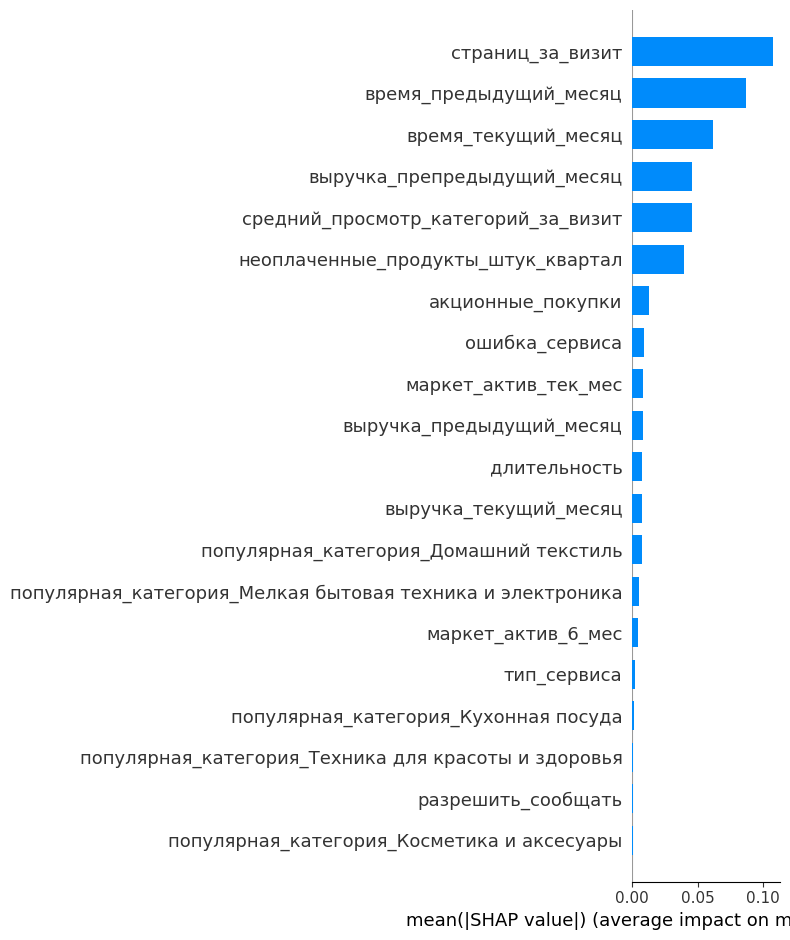

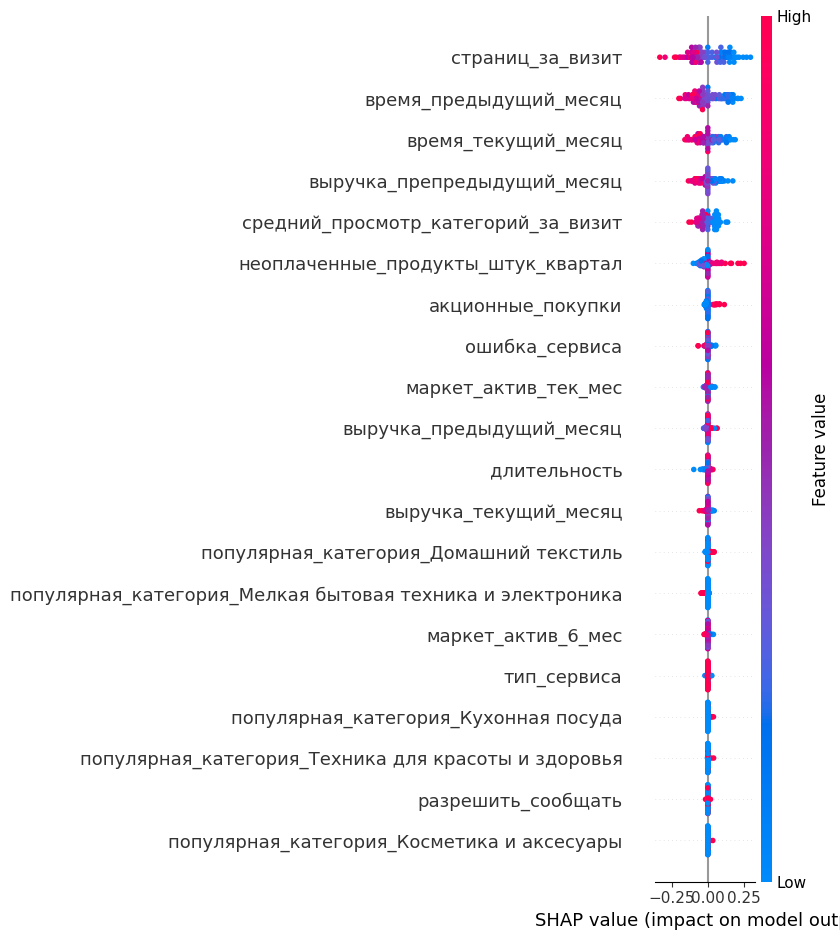

In [73]:
# Строим графики. График bar plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar")

# График beeswarm
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

По результатам анализа модели SVC с использованием SHAP можно сделать следующие выводы:

    Наиболее важные признаки:
- страниц_за_визит — снижение количества просмотренных страниц связано с падением интереса;
- время_предыдущий_месяц и время_текущий_месяц — клиенты, проводящие меньше времени на сайте, чаще снижают активность;
- средний_просмотр_категорий_за_визит — интерес к разным категориям тоже сигнализирует об активности;
- выручка_препредыдущий_месяц — снижение трат может быть первым индикатором снижения активности;
-  неоплаченные_продукты_штук_квартал — клиенты, оставляющие товары в корзине, склонны снижать активность.

    Менее значимые признаки:
- Категории товаров (популярная_категория), тип_сервиса, выручка_текущий_месяц, маркет_актив_, ошибка_сервиса — их влияние на предсказания минимально, модель почти не опирается на них.

    Как можно это использовать?
- Следить за снижением времени и количества просмотров — устраивать дополнительные коммуникации с клиентами;
- Создавать персонализированные предложения для клиентов, у которых стали снижаться траты или вовлечённость;
- Работать с клиентами, которые оставляют товары в корзине — возвращать их через напоминания и спецпредложения.



## Сегментация покупателей

**Выполним сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.**

    Необходимо:
	1.	Получить предсказанную вероятность снижения активности;
	2.	Объединить с таблицей money, где хранится прибыль по каждому клиенту;
	3.	Выделить сегмент с высокой вероятностью снижения активности и высокой прибылью, так как именно их особенно важно удерживать.

In [74]:
# добавляем  в итоговую таблицу данные из money— теперь у нас есть прибыль каждого клиента
final_data_with_profit = final_data.merge(money, on='id', how='left')

# Добавляем предсказанную вероятность снижения активности
final_data_with_profit['probability'] = best_svc.predict_proba(X)[:, 1]

# Выделяем сегмент: высокая вероятность и высокая прибыль
high_risk_profitable = final_data_with_profit[
    (final_data_with_profit['probability'] > 0.7) &
    (final_data_with_profit['прибыль'] > final_data_with_profit['прибыль'].median())
]

print(f"Размер сегмента: {len(high_risk_profitable)} клиентов")
high_risk_profitable.head()

Размер сегмента: 192 клиентов


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прибыль,probability
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,0.955947
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,0.981469
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93,0.987826
9,215360,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6,4.55,0.726118
17,215368,1,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,5823.0,4536.0,5591.6,11,9,6.27,0.986901


Мы получили сегмент из 197 клиентов с:

	•	высокой вероятностью снижения активности (> 0.7),
	•	высокой прибылью (выше медианного значения по всем клиентам).

**Проведем графическое и аналитическое исследование группы покупателей.**

In [75]:
#Описательная статистика количественных признаков
high_risk_profitable.describe().T

,count,mean,std,min,25%,50%,75%,max
id,192.0,215581.994792,191.885505,215349.000000,215459.750000,215564.000000,215651.250000,216636.000000
покупательская_активность,192.0,0.973958,0.159676,0.000000,1.000000,1.000000,1.000000,1.000000
маркет_актив_6_мес,192.0,3.503125,1.013826,0.900000,2.975000,3.800000,4.100000,5.800000
маркет_актив_тек_мес,192.0,4.046875,0.688644,3.000000,4.000000,4.000000,5.000000,5.000000
длительность,192.0,624.598958,233.616929,163.000000,456.250000,625.500000,806.500000,1076.000000
акционные_покупки,192.0,0.471927,0.297694,0.120000,0.250000,0.320000,0.890000,0.990000
средний_просмотр_категорий_за_визит,192.0,2.354167,1.092374,1.000000,2.000000,2.000000,3.000000,6.000000
неоплаченные_продукты_штук_квартал,192.0,4.046875,2.237915,0.000000,2.000000,4.000000,5.250000,10.000000
ошибка_сервиса,192.0,3.843750,1.846622,0.000000,2.000000,3.000000,5.000000,8.000000
страниц_за_визит,192.0,4.192708,1.978775,1.000000,3.000000,4.000000,5.000000,11.000000


In [76]:
#Смотрим распределение категориальных признаков в сегменте

high_risk_profitable['тип_сервиса'].value_counts(normalize=True)

тип_сервиса
стандарт    0.645833
премиум     0.354167
Name: proportion, dtype: float64

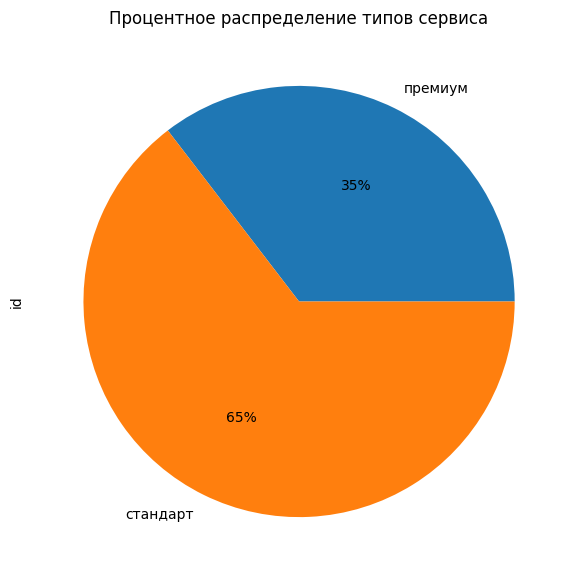

In [77]:
(
high_risk_profitable
    .pivot_table(index='тип_сервиса',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), legend=False)
)
plt.title('Процентное распределение типов сервиса')
plt.show()

In [78]:
high_risk_profitable['разрешить_сообщать'].value_counts(normalize=True)

разрешить_сообщать
да     0.723958
нет    0.276042
Name: proportion, dtype: float64

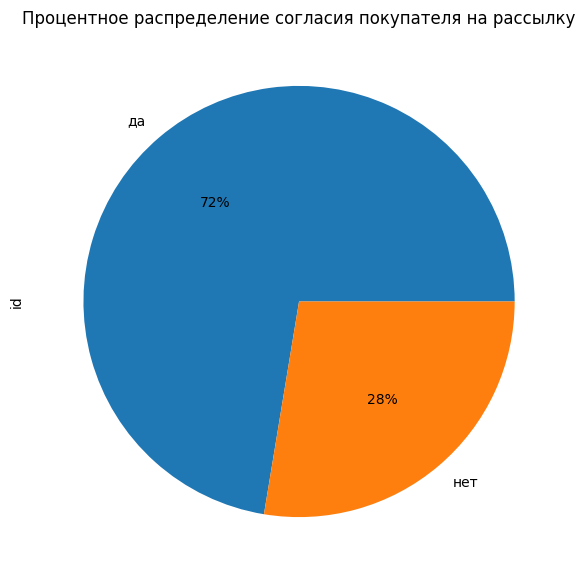

In [79]:
(
high_risk_profitable
    .pivot_table(index='разрешить_сообщать',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), legend=False)
)
plt.title('Процентное распределение согласия покупателя на рассылку')
plt.show()

In [80]:
high_risk_profitable['популярная_категория'].value_counts(normalize=True)

популярная_категория
Товары для детей                        0.333333
Косметика и аксесуары                   0.234375
Домашний текстиль                       0.177083
Кухонная посуда                         0.119792
Техника для красоты и здоровья          0.088542
Мелкая бытовая техника и электроника    0.046875
Name: proportion, dtype: float64

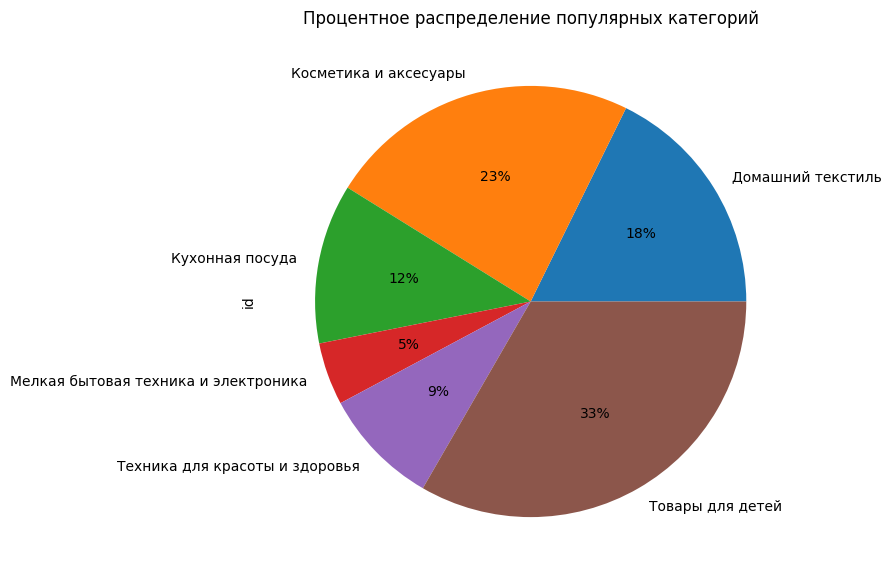

In [81]:
(
high_risk_profitable
    .pivot_table(index='популярная_категория',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), legend=False)
)
plt.title('Процентное распределение популярных категорий')
plt.show()

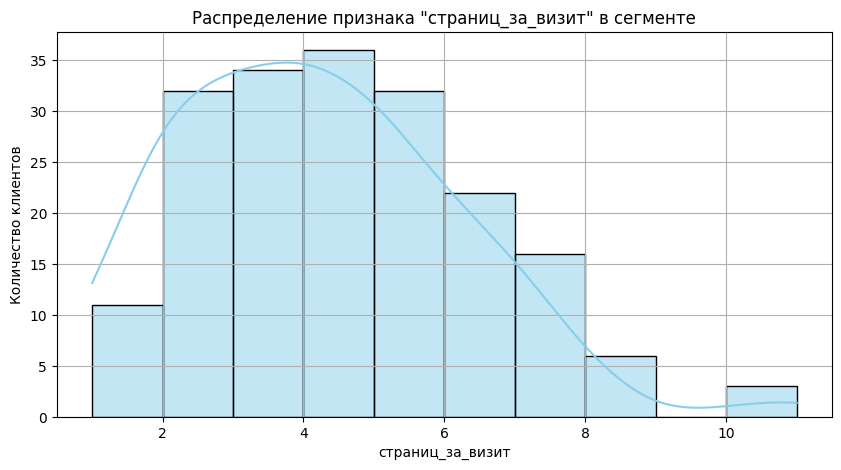

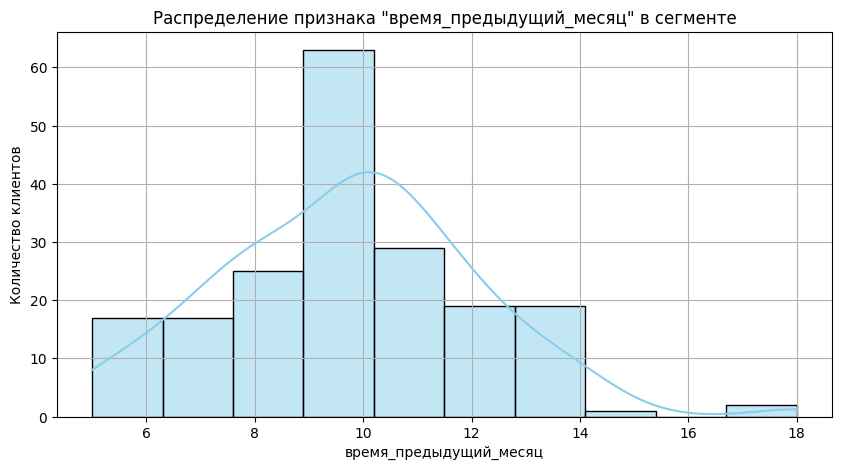

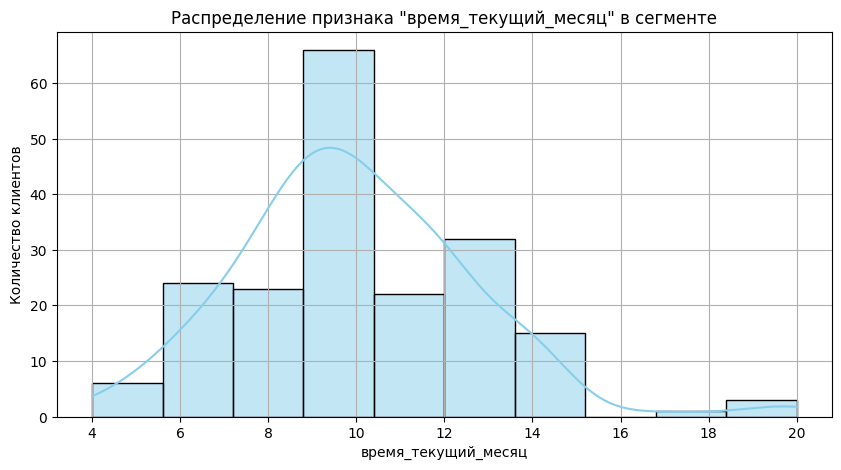

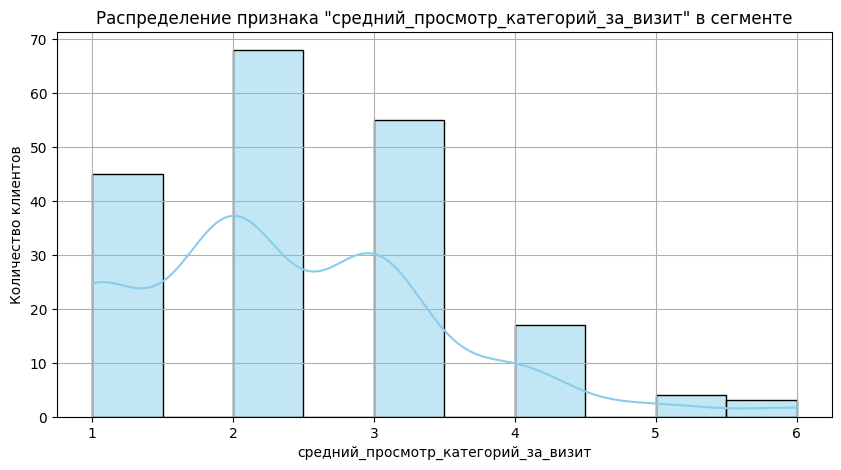

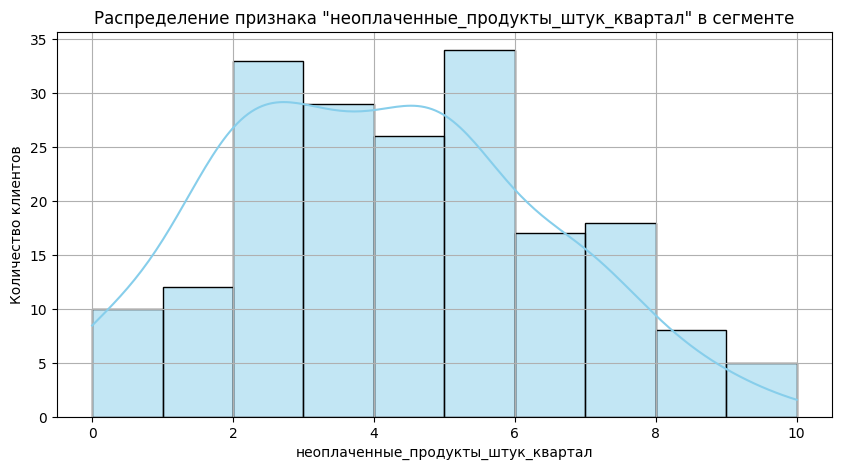

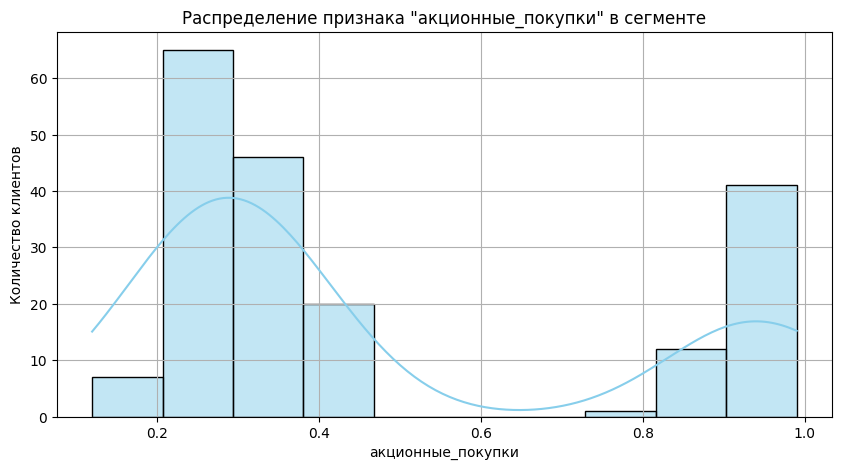

In [82]:
# построим гистограммы распределения ключевых признаков

# список признаков по важности SHAP
top_features = [
    'страниц_за_визит',
    'время_предыдущий_месяц',
    'время_текущий_месяц',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'акционные_покупки'
]

# Построение гистограмм
for feature in top_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(high_risk_profitable[feature], bins=10, kde=True, color='skyblue')
    plt.title(f'Распределение признака "{feature}" в сегменте')
    plt.xlabel(feature)
    plt.ylabel('Количество клиентов')
    plt.grid(True)
    plt.show()

1. страниц_за_визит - большинство клиентов просматривают 4–6 страниц за визит.Это значит что покупатели достаточно активно изучают ассортимент, но не переходят к большому числу страниц. Возможно, их интерес концентрируется на ограниченном наборе товаров — это шанс предложить более широкий выбор в любимых категориях.

2. время_предыдущий_месяц и время_текущий_месяц - в обоих периодах  клиенты в основном проводят на сайте 8–12 минут, пиковое время около 10 минут. Распределение немного скошено вправо. Это говорит о стабильном интересе — можно попробовать удержать их персональными предложениями на основе истории покупок или действий на сайте.

3. средний_просмотр_категорий_за_визит - чаще всего за визит просматривается 2–3 категории, редко больше 4. Это означает, что клиенты интересуются узким набором категорий  и у них уже сформированы предпочтения. Можно попробовать  предложить им смежные или сопутствующие товары.

4. неоплаченные_продукты_штук_квартал -  многие клиенты оставляют 2–6 товаров в корзине без оплаты. Есть большой потенциал для реанимации таких корзин. Например -  запустить автоматические напоминания или акции на такие товары.

5. акционные_покупки -  бимодальное распределение — часть клиентов покупает много по акции (около 1.0), часть — почти не покупает по акциям. Значит в нашем сегменте есть две подгруппы:
	•	те, кто реагирует на скидки — им подойдут персональные акции;
	•	и те, кому важны другие факторы (качество, удобство и пр.) — им стоит делать персональные подборки без акцента на скидку.

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


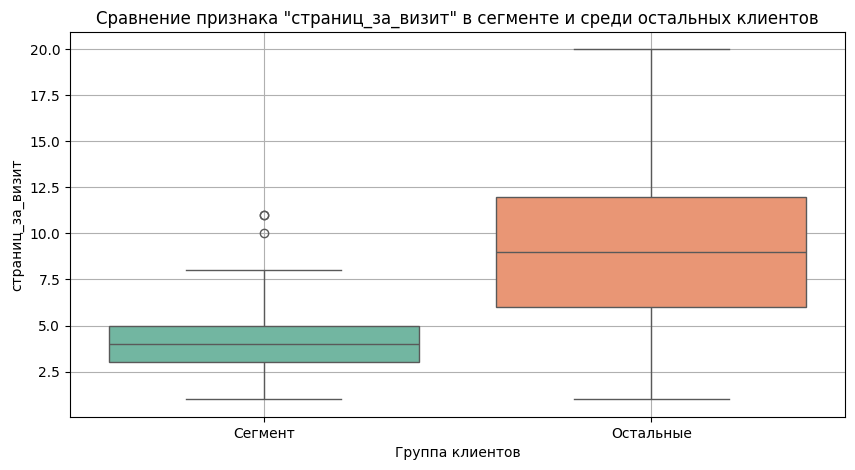

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


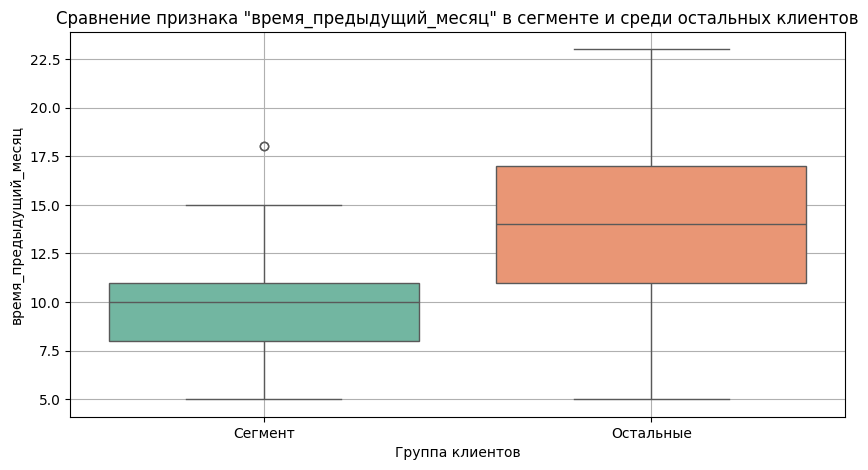

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


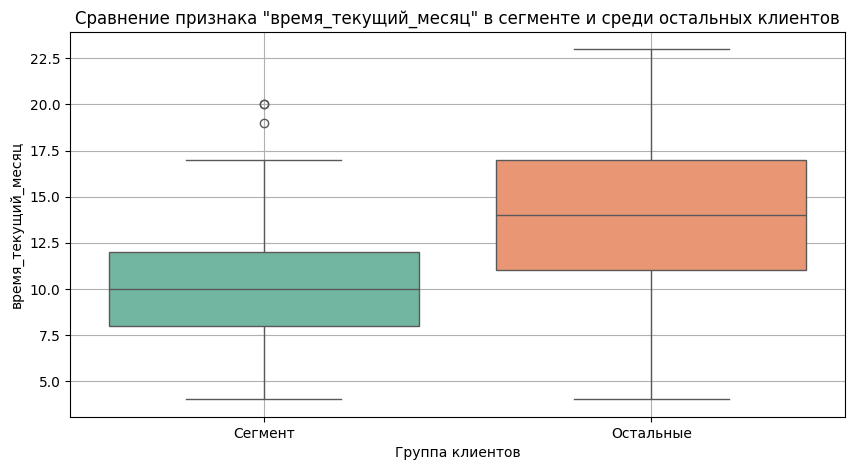

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


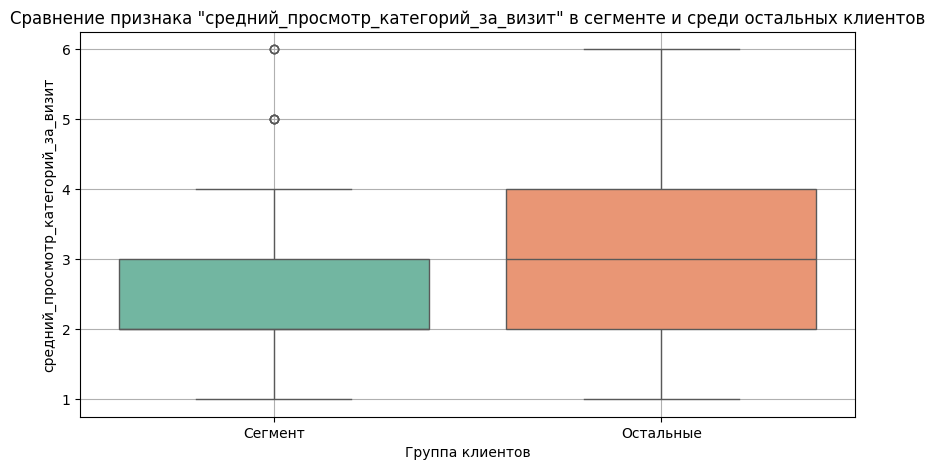

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


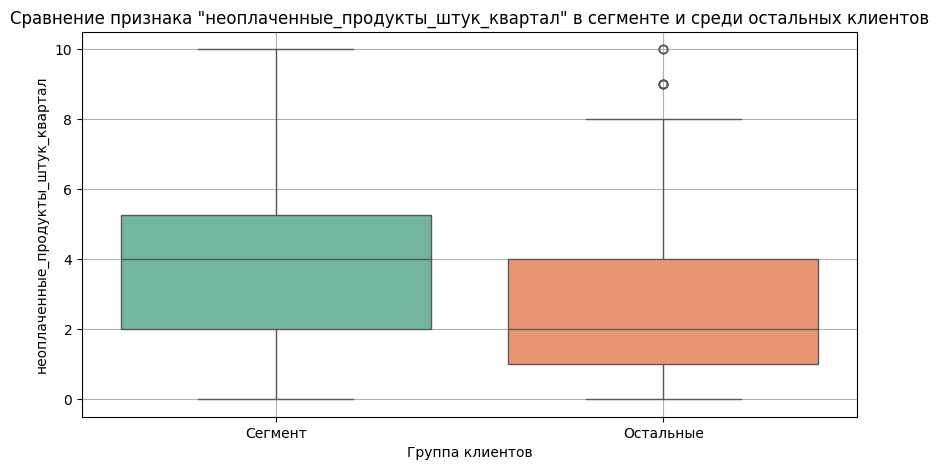

/var/folders/yh/8zfzhbdx1hx04lj55rfsh92c0000gn/T/ipykernel_3353/185634982.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')


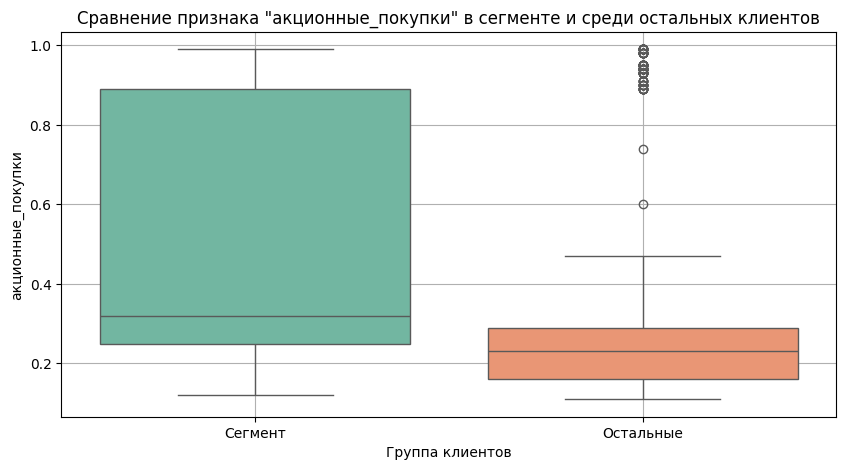

In [83]:
# Построим boxplot для сравнения сегмента с другими клиентами

# Добавим колонку-сегмент для сравнения (если ещё не добавляли)
final_data_with_profit['сегмент'] = final_data_with_profit['id'].isin(high_risk_profitable['id']).map({True: 'Сегмент', False: 'Остальные'})

# Построим boxplot для каждого признака из top_features
for feature in top_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='сегмент', y=feature, data=final_data_with_profit, palette='Set2')
    plt.title(f'Сравнение признака "{feature}" в сегменте и среди остальных клиентов')
    plt.xlabel('Группа клиентов')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

1. страниц_за_визит
	- клиенты сегмента смотрят меньше страниц за визит, остальные - активнее в изучении сайта, выше разброс.
	Значит клиенты из сегмента быстро уходят, не интересуются широким выбором, стоит вовлекать их через персональные подборки и рекомендации.


2. время_предыдущий_месяц и время_текущий_месяц
	- клиенты сегмента проводят меньше времени на сайте, медиана и разброс ниже, остальные -  остаются на сайте дольше.
	Значит покупатели из сегмента быстро теряют интерес, можно предложить вовлекающий контент (обзоры, видео, подборки) или персональные акции, чтобы задержать их на сайте.


3. средний_просмотр_категорий_за_визит
	- клиенты сегмента просматривают меньше категорий, активность ограничена 1–2 категориями. Стоит рекомендовать соседние или смежные категории, расширяя интерес к ассортименту.


4. неоплаченные_продукты_штук_квартал
	- клиенты сегмента имеют чуть больше незавершённых покупок в корзине (выше медиана). Возможно, пользователи сомневаются в покупке и им стоит делать напоминания, персональные скидки на незавершённые товары.


5. акционные_покупки
	- клиенты сегмента имеют чётко выраженное предпочтение акциям — у многих доля акционных покупок близка к 1. Значит для них подойдут акционные предложения, скидки, промокоды.

**Выводы о сегментах**


Для дополнительного анализа был выбран сегмент клиентов с **высокой вероятностью снижения активности и одновременно с высокой прибылью** (выше медианного значения по выборке). Именно этот сегмент был выбран по следующим причинам:
- Эти клиенты приносят компании наибольшую выгоду, и их потеря наиболее критична для бизнеса.
- Модель показывает, что они с высокой вероятностью могут перейти статус некактивных, поэтому важно вовремя на это отреагировать.
- Именно на этой группе усилия по удержанию дадут максимальный результат и возврат потраченных средств — проще удержать хорошего клиента, чем найти нового с таким же уровнем прибыли.



На основе анализа поведения сегмента были сделаны **следующие предложения**:

1. **Акцент на акции и скидки:**
   - Клиенты часто покупают товары по акции, поэтому стоит предложить персональные скидки, участие в распродажах, промокоды.


2. **Рассылки с подборками и напоминаниями:**
   - 73% согласны получать сообщения — это даёт возможность использовать email рассылки  и push-уведомления с подборками акционных товаров или напоминаниями о товарах в корзине.


3. **Стимулирование вовлечённости:**
   - Покупатели меньше времени проводят на сайте и смотрят меньше категорий, что может говорить о потере интереса.
   - Рекомендуется предложить вовлекающий контент, персональные рекомендации. Напоминать о забытых товарах в корзине и предлагать промокоды, чтобы завершить покупки


4. **Фокус на популярных категориях:**
   - «Товары для детей», «Косметика» и «Домашний текстиль» — самые частые выборы, значит, предложения должны быть нацелены именно на эти группы товаров.


    Цель всех предложений — удержать прибыльных клиентов, которые находятся на грани снижения активности, через персонализированные и ценные для них коммуникации.

## Общий вывод

   Задачей проекта было разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

   В распоряжении были четыре таблицы с информацией о:

- поведении клиентов на сайте,
- маркетинговых коммуникациях,
- выручке и времени на сайте по месяцам,
- прибыли от каждого клиента за 3 месяца.


   Предобработка данных включала:
- Приведение всех названий столбцов к единому стилю.
- Обнаружение и исправление опечаток в категориальных признаках.
- Проверку на пропуски и дубликаты, их не оказалось.


   На этапе исследовательского анализа данных:
- Изучены все количественные и категориальные признаки.
- Построены гистограммы и диаграммы размаха для всех количественных признаков, круговые диаграммы для категориальных.
- Выявлены несколько аномальных значений, которые было принято решение отбросить из рассмотрения. 
- Отобраны клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период.

   Затем проведено объединение таблицы market_file.csv, market_money.csv, market_time.csv.  В итоговой таблице сделан отдельный столбец для каждого периода.
   
   Корреляционный анализ показал:
- наличие связи только между признаками 'выручка_текущий_месяц' и 'время_предыдущий_месяц' = 0,84
- между входными параметрами отсутствует связь выше 0,9 следовательно мультиколлинеарность отсутсвует и учитывать ее при обучении модели не нужно

   На этапе моделанирования обучены четыре разные модели, чтобы предсказывать, снизится ли покупательская активность клиента. Для оценки качества моделей использовали метрику F1-мера, потому что у нас есть небольшой дисбаланс классов.
   Сначала были обучены базовые версии моделей, затем — выполнен подбор лучших гиперпараметров с помощью GridSearchCV. 

   Модель KNeighborsClassifier показала чуть лучшее качество (F1-мера: 0.838), но она не поддерживает оценку важности признаков — SHAP с ней работает плохо или не работает вообще.
Модель SVC дала очень близкий результат (F1-мера: 0.835) и при этом совместима с SHAP.
Разница в качестве между моделями минимальна (всего 0.003), поэтому принято решение использовать SVC для анализа.

   Метод **опорных векторов (SVC)** после подбора гиперпараметров (ядро RBF, `C=1`, `gamma=scale`) показал лучшую F1-меру: 0.878 на тестовой выборке.


   С помощью SHAP проведён анализ важности признаков. Наиболее значимые признаки:
- количество просмотренных страниц за визит;
- время, проведённое на сайте;
- количество непросмотренных категорий и акционные покупки.

   Даны рекомендации следить за снижением времени и количества просмотров — устраивать дополнительные коммуникации с клиентами, создавать персонализированные предложения для клиентов, у которых стали снижаться траты или вовлечённость.
   
   Выполнена сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей - был выделен сегмент **прибыльных клиентов с высокой вероятностью снижения активности** — 197 человек.

📌 Итоговые предложения:
- Персональные скидки и акции (сегмент чувствителен к акциям).
- Напоминания и рекомендации через рассылки (73% согласны получать уведомления).
- Повышение вовлечённости: вовлекающих контент, спецпредложения при просмотре новых категорий.
- Сосредоточиться на товарах из наиболее популярных категорий: детские товары, косметика, текстиль.

---

  В завершении можно сказать, что модель SVC успешно решает задачу прогнозирования снижения активности. Использование этой модели вместе с анализом прибыльности помогает **точно выявлять клиентов, которые вероятно низят активность** и применять  меры для их удержания, что может существенно повысить общую покупательскую активность и выручку магазина.